# LIBRARIES IMPORTATION

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
from shapely.validation import make_valid
from shapely.ops import unary_union
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Note: Geopandas is the combination of pandas and geography, it is table a with spatial geometries, it works with spatial data such as lines, polygons and points. It is used for shapefiles, geojsons, boundaries e.t.c. Here i used it for a .shp file. Shapely handles geometry objects, it is used to create and manipulate polygons.

In [2]:
# Load and read data.
polygon = gpd.read_file(r"C:\Users\DELL\AssessmentTask\test.shp")

In [3]:
# Display the first 5 rows.
polygon.head()

,fid,id,confidence,prompt,area,geometry
0,1.0,0.0,0.692769,building,103062.0,"POLYGON ((317396.777 1011679.656, 317396.947 1..."
1,2.0,2.0,0.564857,building,81849.5,"POLYGON ((317402.735 1011693.036, 317402.939 1..."
2,3.0,7.0,0.549252,building,98148.5,"POLYGON ((317407.127 1011685.273, 317407.502 1..."
3,4.0,10.0,0.684285,building,21245.0,"POLYGON ((317389.252 1011670.02, 317389.355 10..."
4,5.0,11.0,0.780945,building,21.5,"POLYGON ((317406.412 1011690.414, 317406.548 1..."


In [4]:
# Check details about the data
polygon.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         20 non-null     float64 
 1   id          20 non-null     float64 
 2   confidence  20 non-null     float64 
 3   prompt      20 non-null     object  
 4   area        20 non-null     float64 
 5   geometry    20 non-null     geometry
dtypes: float64(4), geometry(1), object(1)
memory usage: 1.1+ KB


In [5]:
# To check if there are multi polygon
polygon.geom_type

0     Polygon
1     Polygon
2     Polygon
3     Polygon
4     Polygon
5     Polygon
6     Polygon
7     Polygon
8     Polygon
9     Polygon
10    Polygon
11    Polygon
12    Polygon
13    Polygon
14    Polygon
15    Polygon
16    Polygon
17    Polygon
18    Polygon
19    Polygon
dtype: object

In [6]:
# Checking for missing values
missing = polygon.isna().sum()
missing[missing > 0]

Series([], dtype: int64)

In [7]:
# Checking for duplicates.
polygon.duplicated().sum()

np.int64(0)

In [8]:
# Check bounds
bounds = polygon.total_bounds
print(f"Bounds (minx, miny, maxx, maxy): {bounds}")

Bounds (minx, miny, maxx, maxy): [ 317372.46724538 1011663.55126356  317420.37151508 1011702.43305176]


Bounds show the smallest rectangle that fully contains a polygon, represented as (minx, miny, maxx, maxy):

minx: leftmost X coordinate (smallest X)
maxx: rightmost X coordinate (largest X)
miny: bottom Y coordinate (smallest Y)
maxy: top Y coordinate (largest Y)

Example from the dataset:
minx = 317372.467 
maxx = 317420.371
miny = 1011663.551 
maxy = 1011702.433 

Horizontal width = maxx – minx = 48 m
Vertical height = maxy – miny = 39 m

This matches the small environment seen in the image (kub5.tif).

Why bounds are useful:
Check the size of a polygon
Bounds help understand how big the polygon is and where it is located in the coordinate system.


<Figure size 1000x1000 with 0 Axes>

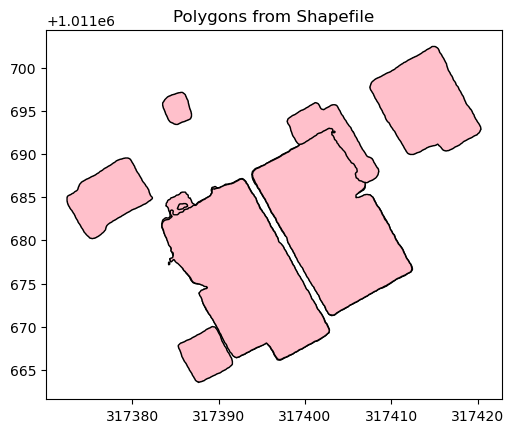

In [9]:
# Visualize the polygon
plt.figure(figsize = (10, 10))
polygon.plot(color = 'pink', edgecolor = 'black')
plt.title("Polygons from Shapefile")
plt.show()

# CLEANING POLYGONS

In [10]:
# Fixing invalid polygons by making them closed and valid
polygon['geometry'] = polygon['geometry'].apply(make_valid)
print(f'All polygons are valid now {polygon.is_valid.all()}')

All polygons are valid now True


In [11]:
# Calculate the area of each geometry and assign to a new column Area.
polygon['Area'] = polygon['geometry'].area

In [12]:
polygon.head()

,fid,id,confidence,prompt,area,geometry,Area
0,1.0,0.0,0.692769,building,103062.0,"POLYGON ((317396.777 1011679.656, 317396.947 1...",119.469988
1,2.0,2.0,0.564857,building,81849.5,"POLYGON ((317402.735 1011693.036, 317402.939 1...",94.880351
2,3.0,7.0,0.549252,building,98148.5,"POLYGON ((317407.127 1011685.273, 317407.502 1...",113.774234
3,4.0,10.0,0.684285,building,21245.0,"POLYGON ((317389.252 1011670.02, 317389.355 10...",24.627311
4,5.0,11.0,0.780945,building,21.5,"POLYGON ((317406.412 1011690.414, 317406.548 1...",0.024923


The dataset had an existing area column, but I didn’t know how it was calculated or what units it used. Some of the original area values were very large and didn’t fit the small environment I see in the image (kub5.tif file). Since area depends on the coordinates and the projection, I recalculated the area directly from each polygon’s geometry using a meter-based coordinate system. When I compared the original values with my new calculations, they were different, which showed that the original numbers might not be reliable. The recalculated areas match the polygon sizes and the environment, and that is what i will use.


In [13]:
# To remove very small artifacts (unwanted polygon noise).
max_area = polygon['Area'].max()
min_area = max_area * 0.005 # Defining the minimum area threshold
len_before = len(polygon)

# Keep only polygons larger than the threshold
polygon = polygon[polygon['Area'] >= min_area]

# Count how many polygons were removed
removed = len_before - len(polygon)

# Print results
print(f"Removed {removed} tiny polygons")
print(f"Remaining: {len(polygon)} polygons")


Removed 9 tiny polygons
Remaining: 11 polygons


In [14]:
tolerance = 1.3 # lower = more detail, higher = smoother
# Total vertices before simplification
vertices_before = polygon['geometry'].apply(lambda g: len(g.exterior.coords)).sum()
# Simplify geometry, removing jagged, stair-step edges 
polygon['geometry'] = polygon['geometry'].simplify(tolerance, preserve_topology = True)

vertices_after = polygon['geometry'].apply(lambda g: len(g.exterior.coords)).sum()
reduction = 100 * (1 - vertices_after / vertices_before)

print(f"Smoothed jagged edges")
print(f"Vertices reduced by {reduction:.1f}%")

Smoothed jagged edges
Vertices reduced by 99.1%


g.exterior.coords gives the coordinates of the polygon’s outer boundary

In [15]:
# Smooths sharp corners using buffer trick
buffer_size = 0.5  # Size of buffer to round corners

#  Expand polygons slightly and then shrink back
polygon['geometry'] = polygon['geometry'].buffer(buffer_size).buffer(-buffer_size)
print(f'"Rounded sharp corners (buffer={buffer_size})')

"Rounded sharp corners (buffer=0.5)


Why did i expand polygons slightly and then shrink back?
Expand pushes the edge outwards and round sharp coners.
Shrink keeps the shape but corners smoote.
At the end jagged corners are rounded without changing the overall polygon too much.

In [16]:
min_hole_area = 0.01 * polygon['Area'].max()  

In [17]:
# Check unique geometry types currently in the dataframe
print(polygon.geom_type.unique())

['Polygon']


In [18]:
# Remove tiny holes inside polygons
def remove_tiny_holes(polygon_geom):
    # Keep only large holes
    large_holes = [h for h in polygon_geom.interiors if Polygon(h).area >= min_hole_area]
    return Polygon(polygon_geom.exterior, holes=large_holes)

# Count holes before cleaning
holes_before = sum(len(g.interiors) for g in polygon['geometry'])

# Remove tiny holes
polygon['geometry'] = polygon['geometry'].apply(remove_tiny_holes)

# Count holes after cleaning
holes_after = sum(len(g.interiors) for g in polygon['geometry'])

print(f"Removed {holes_before - holes_after} tiny holes")
print(f"Preserved {holes_after} significant holes")


Removed 0 tiny holes
Preserved 0 significant holes


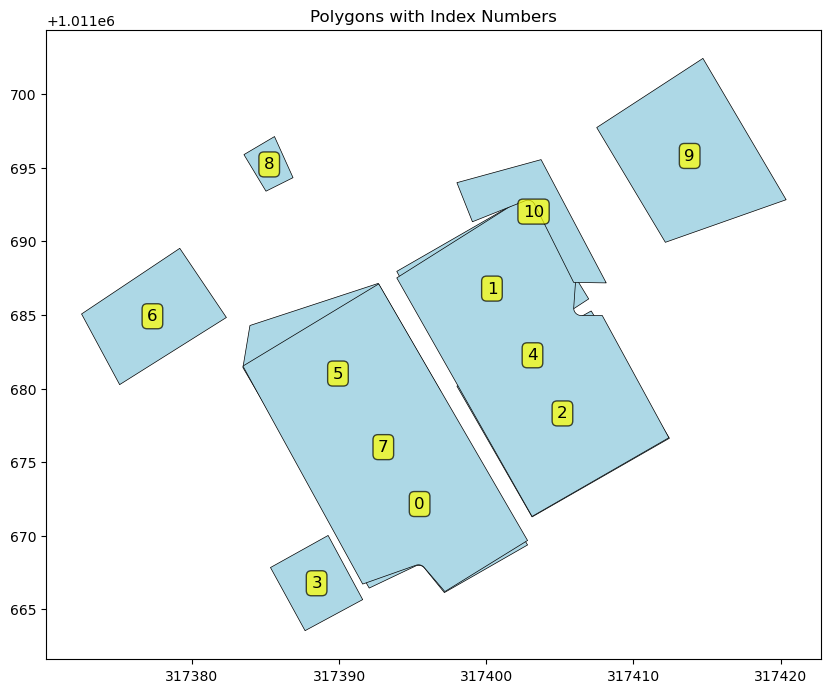

In [19]:
# Visualize Polygons with Indices
# Reset index to make it clearer
polygon = polygon.reset_index(drop = True)

fig, ax = plt.subplots(figsize = (10, 10))
polygon.plot(ax = ax, color = 'lightblue', edgecolor='black', linewidth=0.5)

# Add index labels at centroid of each polygon
for idx, row in polygon.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, str(idx), fontsize = 12, ha = 'center', va = 'center',
            bbox = dict(boxstyle = 'round', facecolor = 'yellow', alpha = 0.7))

ax.set_title('Polygons with Index Numbers')
plt.show()


In [20]:
def merge_polygons_by_index(gdf, indices_to_merge, buffer_distance=1.0, keep_largest=True):
    """
    Merge polygons at specified indices into a single polygon.
    """
    # Separate polygons 
    polygons_to_merge = gdf.loc[indices_to_merge].copy()
    polygons_to_keep = gdf.drop(indices_to_merge).copy()

    # Buffer to connect, then merge 
    buffered = polygons_to_merge.geometry.buffer(buffer_distance)
    merged_buffered = unary_union(buffered)

    # Remove buffer expansion 
    merged_geometry = merged_buffered.buffer(-buffer_distance)

    # Handle MultiPolygon 
    if merged_geometry.geom_type == "MultiPolygon":
        if keep_largest:
            merged_geometry = max(merged_geometry.geoms, key = lambda g: g.area)
        else:
            # Keep all parts as MultiPolygon
            pass

    # Create merged row 
    merged_row = gpd.GeoDataFrame(
        {"geometry": [merged_geometry], "Area": [merged_geometry.area]}, crs = gdf.crs)

    # Combine back and reset index
    result = gpd.GeoDataFrame(pd.concat([polygons_to_keep, merged_row], ignore_index = True),  crs = gdf.crs)
    return result


crs stands for Coordinate Reference System. It defines how the geometric coordinates in your spatial data relate to locations on Earth.
What it does:
This copies the CRS from your original GeoDataFrame (gdf) to ensure the new GeoDataFrame uses the same coordinate system.

In [21]:
print("Original polygon count:", len(polygon))
to_merge_indices_1 = [1, 4, 10, 2]
print(f"\nMerging polygons at indices: {to_merge_indices_1}")

polygon = merge_polygons_by_index(gdf = polygon, indices_to_merge = to_merge_indices_1, buffer_distance = 2.0)
print(f"After first merge: {len(polygon)} polygons")

Original polygon count: 11

Merging polygons at indices: [1, 4, 10, 2]
After first merge: 8 polygons


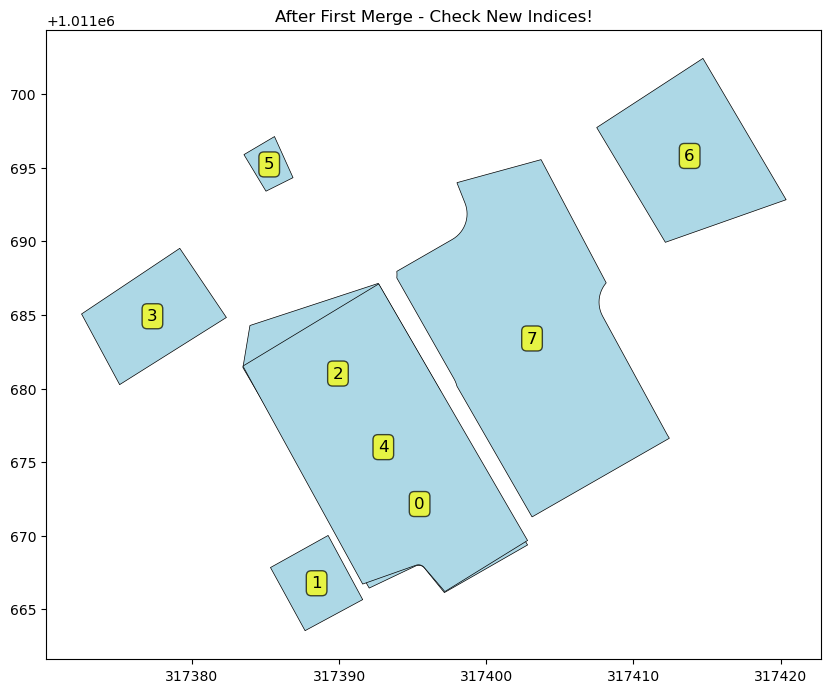

In [22]:
# Visualize after first merge
fig, ax = plt.subplots(figsize = (10, 10))
polygon.plot(ax = ax, color = 'lightblue', edgecolor = 'black', linewidth = 0.5)
for idx, row in polygon.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, str(idx), fontsize = 12, ha = 'center', va = 'center',
            bbox=dict(boxstyle = 'round', facecolor = 'yellow', alpha = 0.7))
ax.set_title('After First Merge - Check New Indices!')
plt.show()


In [23]:
to_merge_indices_2 = [2, 4, 0]  
print(f"\nMerging polygons at indices: {to_merge_indices_2}")

polygon = merge_polygons_by_index(gdf = polygon, indices_to_merge = to_merge_indices_2,  buffer_distance = 1.0)
print(f"After second merge: {len(polygon)} polygons")



Merging polygons at indices: [2, 4, 0]
After second merge: 6 polygons


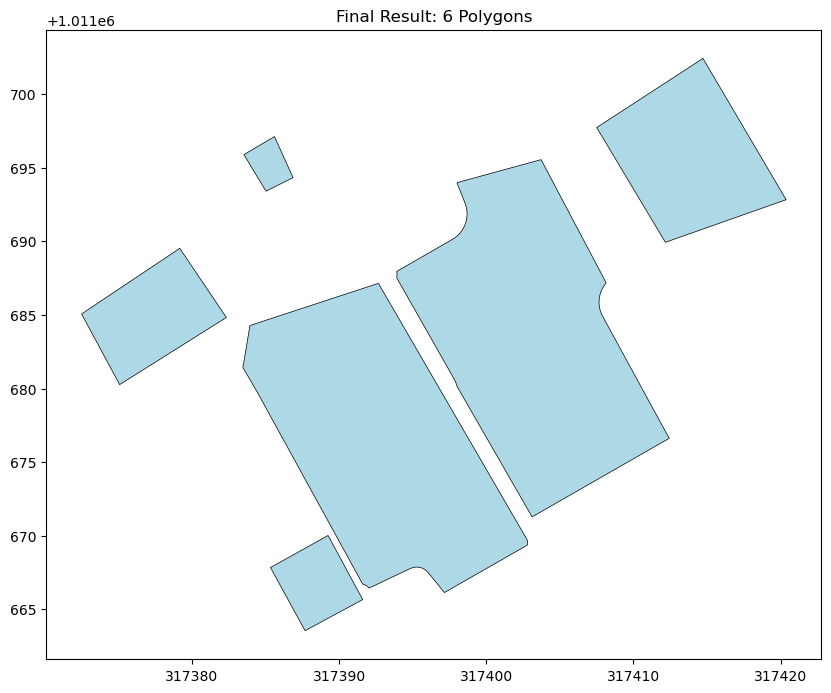

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
polygon.plot(ax = ax, color = 'lightblue', edgecolor = 'black', linewidth = 0.5)
ax.set_title(f'Final Result: {len(polygon)} Polygons')
plt.show()


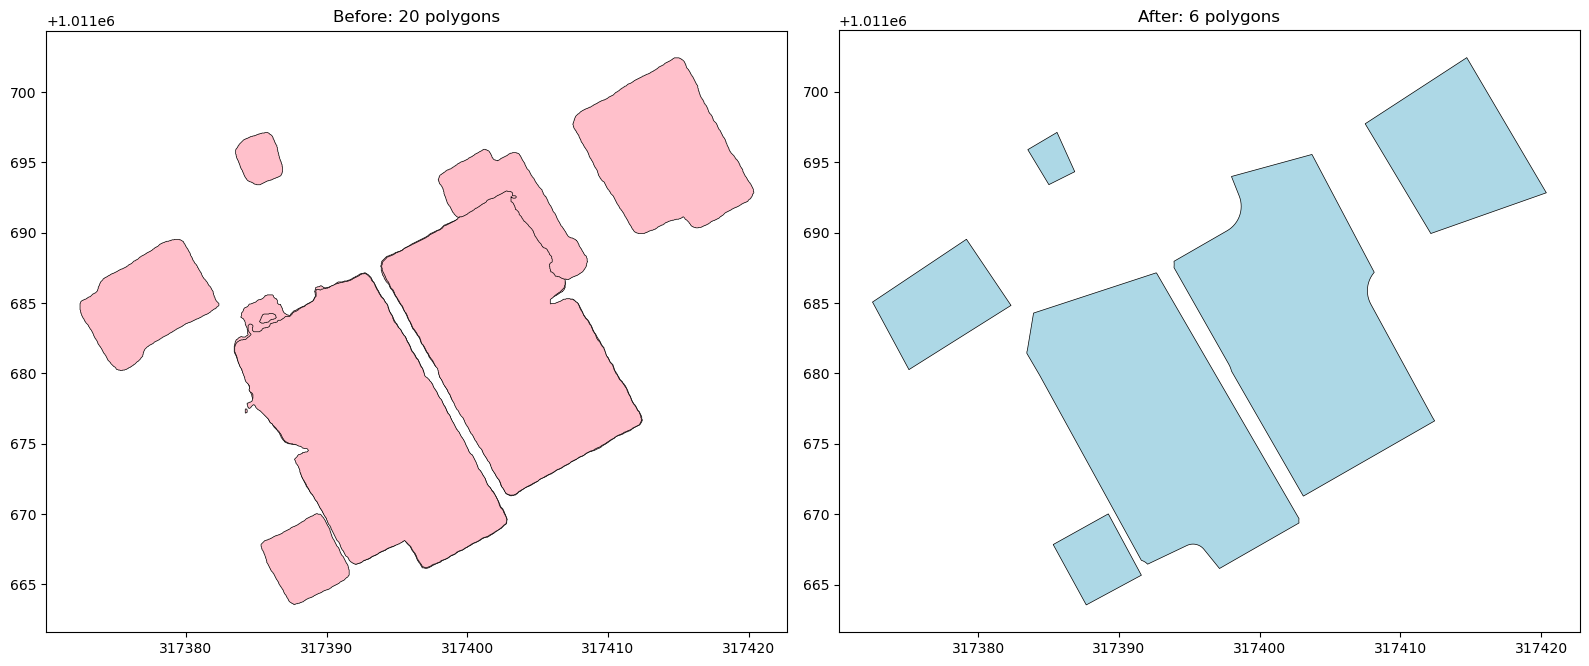

In [25]:
# For the comparison plot, you need to load the original polygons again
original_polygon = gpd.read_file(r"C:\Users\DELL\AssessmentTask\test.shp")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

original_polygon.plot(ax = ax1, color = 'pink', edgecolor = 'black', linewidth = 0.5)
ax1.set_title(f'Before: {len(original_polygon)} polygons')

polygon.plot(ax = ax2, color='lightblue', edgecolor='black', linewidth=0.5)
ax2.set_title(f'After: {len(polygon)} polygons')

plt.tight_layout()
plt.show()

In [26]:
# Export as Shapefile
output_path_shp = r"C:\Users\DELL\AssessmentTask\test_cleaned.shp"
polygon.to_file(output_path_shp)
print(f"Saved to {output_path_shp}")


Saved to C:\Users\DELL\AssessmentTask\test_cleaned.shp


In [27]:
# Export as GeoJSON
output_path_geojson = r"C:\Users\DELL\AssessmentTask\test_cleaned.geojson"
polygon.to_file(output_path_geojson, driver = "GeoJSON")
print(f"Saved to {output_path_geojson}")


Saved to C:\Users\DELL\AssessmentTask\test_cleaned.geojson
